# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import random
import kmapper as km
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import dyneusr as dsr
import netrd.distance.netsimile

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from tmap.tda.utils import optimize_dbscan_eps
from netrd.distance import NetSimile
from tda_cover_parameters_tuning import CoverTuning, GraphProperties

In [12]:
# Set random seed for reproducibility
seed_value = 42

# **Load data**

In [2]:
data_dir = 'your data directory here'

data_1 = pd.read_csv(data_dir + 'file_name.csv')
data_2 = pd.read_csv(data_dir + 'file_name.csv')

sex_labels = pd.read_csv(data_dir + '/sex_labels.csv')
y = pd.get_dummies(sex_labels).astype(int)

# Print dimension
print(data_1.shape)
print(data_2.shape)
print(sex_labels.shape)

(1109, 50)
(1109, 52)
(1109, 1)


In [3]:
# Results matrices
matrix_netsimile_umap_1 = pd.read_csv('matrix_netsimile_umap_1.csv', header=None)
matrix_netsimile_tsne_1 = pd.read_csv('matrix_netsimile_tsne_1.csv', header=None)
matrix_netsimile_umap_2 = pd.read_csv('matrix_netsimile_umap_2.csv', header=None)
matrix_netsimile_tsne_2 = pd.read_csv('matrix_netsimile_tsne_2.csv', header=None)

# Convert to numpy
matrix_netsimile_umap_1 = np.array(matrix_netsimile_umap_1)
matrix_netsimile_tsne_1 = np.array(matrix_netsimile_tsne_1)
matrix_netsimile_umap_2 = np.array(matrix_netsimile_umap_2)
matrix_netsimile_tsne_2 = np.array(matrix_netsimile_tsne_2)


## **Display results matrices**

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
# Resolution and Gain ranges
res = ['0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75']
gain = ['10', '15', '20', '25', '30', '35', '40', '45', '50']

res_range = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75]
gain_range = [10,15,20,25,30,35,40,45,50]

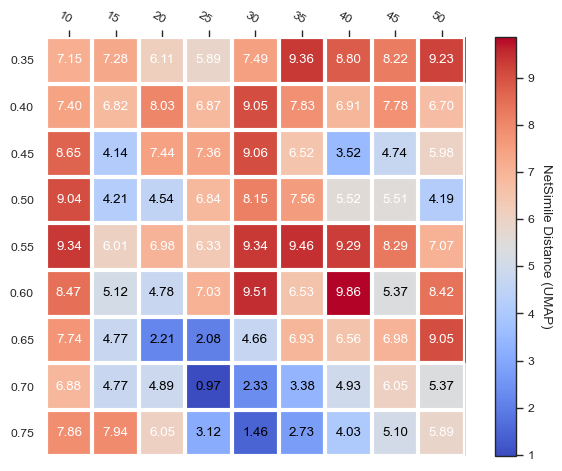

In [6]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_umap_1, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('heatmap_netsimile_umap_1.png')
plt.show()

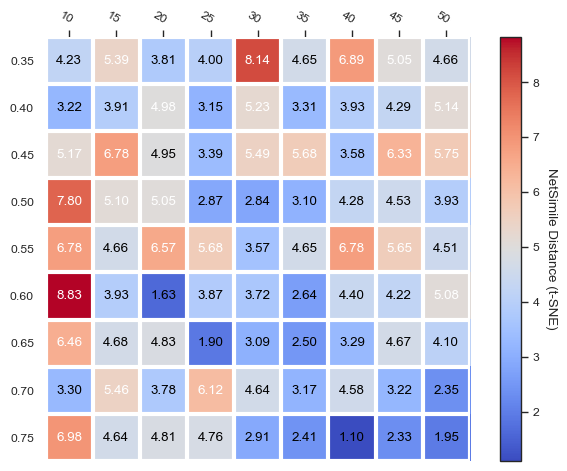

In [7]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_tsne_1, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('heatmap_netsimile_tsne_1.png')
plt.show()

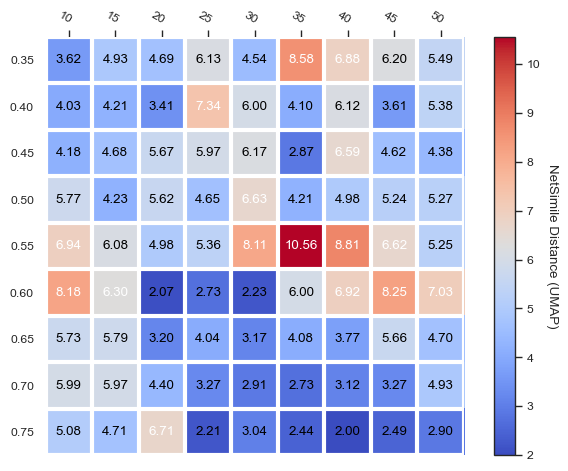

In [8]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_umap_2, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('heatmap_netsimile_umap_2.png')
plt.show()

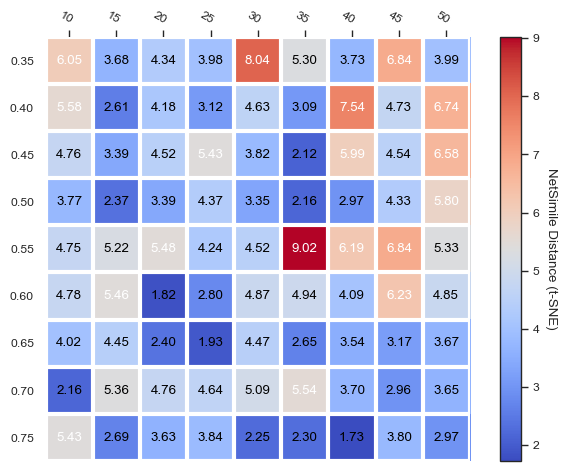

In [9]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_tsne_2, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('heatmap_netsimile_tsne_2.png')
plt.show()

# **Topological Properties Extraction**

In [ ]:
graph_properties = GraphProperties(data_1, projector=UMAP, res=0.70, gain=35, seed=seed_value)
stats = graph_properties.graph_properties_stats()
stats

,node degree,clustering coefficient,average degree of neighborhood,average clustering coefficient of neighborhood,number of edges in the neighborhood,number of outgoing edges from the neighborhood,number of neighbors of neighbors (not in neighborhood)
mean,25.859305,0.674045,28.666307,0.625933,237.614426,329.022262,68.537845
median,27.000000,0.610526,29.771429,0.594582,241.000000,338.000000,72.000000
std,10.473210,0.186097,6.126307,0.102440,128.910525,150.067336,28.393231
skewness,-0.082415,0.620543,-1.743492,2.202957,0.121269,-0.239966,-0.501452
kurtosis,-0.956888,-0.889678,3.926115,5.456584,-1.020665,-0.568428,-0.208811


In [ ]:
# Graph creation
mapper = km.KeplerMapper(verbose=1)
lens = mapper.fit_transform(data_1, projection=UMAP(n_components=2, random_state=seed_value))
graph = mapper.map(lens, X=data_1, 
                   cover=km.Cover(n_cubes=35, perc_overlap=0.70),
                   clusterer=DBSCAN(eps=optimize_dbscan_eps(data_1, threshold=95), min_samples=2))

# Convert to DyNeuSR graph
dyneusr_graph = dsr.DyNeuGraph(G=graph, y=y)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: UMAP(random_state=42)
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1109, 50)

..Projecting data using: 
	UMAP(random_state=42, verbose=1)

UMAP(random_state=42, verbose=1)
Wed Mar 13 16:29:49 2024 Construct fuzzy simplicial set
Wed Mar 13 16:29:49 2024 Finding Nearest Neighbors
Wed Mar 13 16:29:49 2024 Finished Nearest Neighbor Search
Wed Mar 13 16:29:49 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Mar 13 16:29:50 2024 Finished embedding

..Scaling with: MinMaxScaler()

Mapping on data shaped (1109, 50) using lens shaped (1109, 2)

Creating 1225 hypercubes.

Created 14520 edges and 1123 nodes in 0:00:00.855456.


label,group,value,row_count
Gender_F,0,604,1109
Gender_M,1,505,1109


   > Found 0 nodes for data point 7.
   > Found 0 nodes for data point 12.
   > Found 0 nodes for data point 44.
   > Found 0 nodes for data point 55.
   > Found 0 nodes for data point 82.
   > Found 0 nodes for data point 97.
   > Found 0 nodes for data point 115.
   > Found 0 nodes for data point 132.
   > Found 0 nodes for data point 133.
   > Found 0 nodes for data point 161.
   > Found 0 nodes for data point 184.
   > Found 0 nodes for data point 221.
   > Found 0 nodes for data point 254.
   > Found 0 nodes for data point 255.
   > Found 0 nodes for data point 278.
   > Found 0 nodes for data point 280.
   > Found 0 nodes for data point 286.
   > Found 0 nodes for data point 297.
   > Found 0 nodes for data point 313.
   > Found 0 nodes for data point 342.
   > Found 0 nodes for data point 347.
   > Found 0 nodes for data point 351.
   > Found 0 nodes for data point 375.
   > Found 0 nodes for data point 383.
   > Found 0 nodes for data point 385.
   > Found 0 nodes for data poin

In [ ]:
# Graph visualization
dyneusr_graph.visualize('graph_dyneusr.html', show=True)